In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from ast import literal_eval
from sklearn.metrics import classification_report
import gensim.downloader as api
from sklearn.preprocessing import scale

## Utils

In [2]:
# api.BASE_DIR = '/scratch/da2734/twitter/code/11-baseline/logit_glove/downloaded/'
# # api.BASE_DIR 
# import os
# # os.environ['HISTSIZE']
# os.environ['GENSIM_DATA_DIR'] = '/scratch/da2734/twitter/code/11-baseline/logit_glove/downloaded/'

In [2]:
# glove_wiki = api.load("glove-wiki-gigaword-300")

[================================================--] 97.9% 368.4/376.1MB downloaded


In [3]:
# glove_wiki

In [2]:
def get_w2v_general(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

In [3]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [4]:
print('GENSIM_DATA_DIR', os.environ['GENSIM_DATA_DIR'] )

GENSIM_DATA_DIR /scratch/da2734/twitter/code/11-baseline/logit_glove/downloaded


In [5]:
import time
start_time = time.time()
print('loading glove')
glove_twitter = api.load("glove-twitter-200")
print('time taken:', str(time.time() - start_time), 'seconds')    

loading glove
time taken: 228.07656121253967 seconds


************ is_hired_1mo ************
Precision:  0.7894736842105263
Recall:  0.7741935483870968


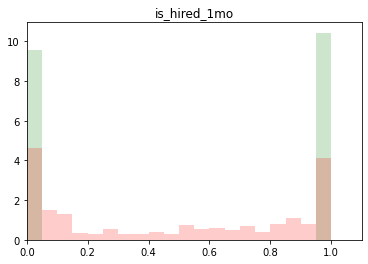

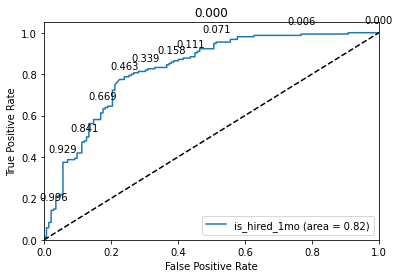

************ is_unemployed ************
Precision:  0.7065217391304348
Recall:  0.7008086253369272


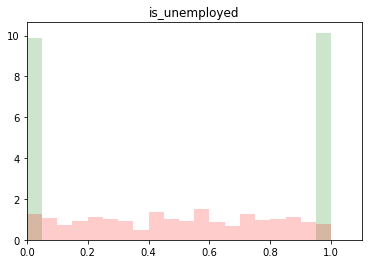

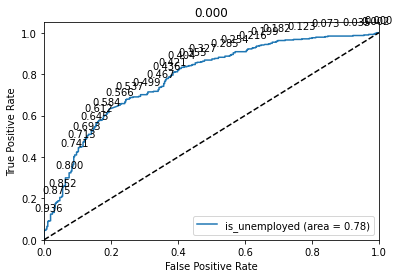

************ job_offer ************
Precision:  0.8904899135446686
Recall:  0.865546218487395


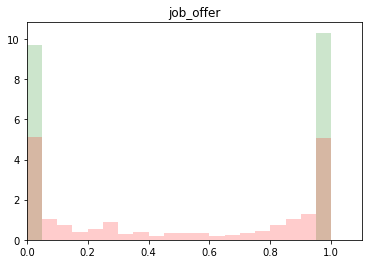

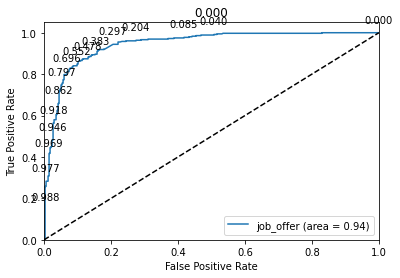

************ job_search ************
Precision:  0.7452830188679245
Recall:  0.7022222222222222


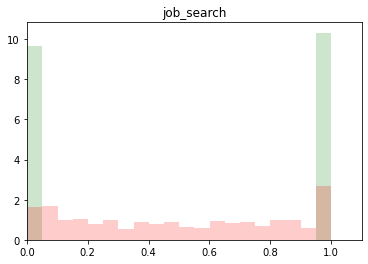

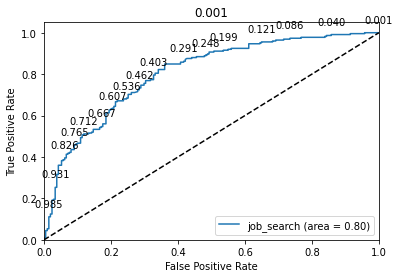

************ lost_job_1mo ************
Precision:  0.7740112994350282
Recall:  0.7569060773480663


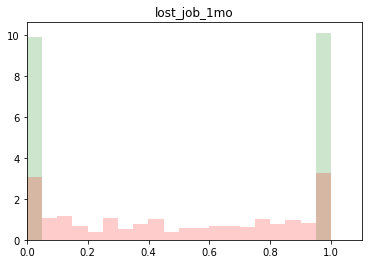

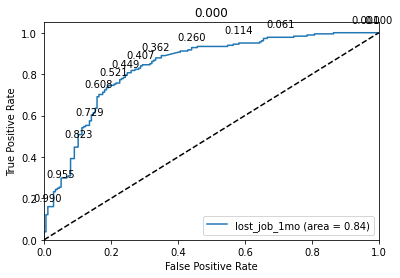

In [26]:
from sklearn.metrics import roc_curve, auc

path = "/scratch/da2734/twitter/data/may20_9Klabels/data_binary_pos_neg_balanced/"
for label in ["is_hired_1mo","is_unemployed","job_offer","job_search","lost_job_1mo"]:
    print("************ {} ************".format(label))
    
    train_file_name = "train_{}.csv".format(label)
    val_file_name = "val_{}.csv".format(label)
    #download data
    df_train = pd.read_csv(os.path.join(path, train_file_name))
#     print(df_train.head())
    df_val = pd.read_csv(os.path.join(path, val_file_name))
    #create embeddings
    train_vecs_glove_mean = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'mean') for z in df_train["text"]]))
    validation_vecs_glove_mean = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'mean') for z in df_val["text"]]))
    #train
    clf = LogisticRegression(max_iter=1000)
    clf.fit(train_vecs_glove_mean,df_train["class"])
    #evaluate
    df_val["class_predict"] = clf.predict(validation_vecs_glove_mean)
#     print(clf.predict_proba(validation_vecs_glove_mean))
#     df_val[["prob_neg", "prob_pos"]] = clf.predict_proba(validation_vecs_glove_mean)
    model_proba = pd.DataFrame(data=clf.predict_proba(validation_vecs_glove_mean), columns = ['glove_neg_model', 'glove_pos_model'])
#     print(model_proba)
    
    df_val = pd.concat([df_val, model_proba], axis = 1) 
    
#     print(df_val.head())
    TP, FP, TN, FN = perf_measure(df_val["class"], df_val["class_predict"])
    print("Precision: ", TP/(TP+FP))
    print("Recall: ", TP/(TP+FN))
    
#     print(df_val.head())
    
#     merged = all_pred[column]
    
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(df_val['class'], bins=20, density = True, color = 'green', alpha = 0.2)
#     plt.hist(merged['neg'], bins=20, density = True, color = 'green', alpha = 0.2)

    plt.hist(df_val['glove_pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
#     plt.hist(merged['neg'], bins=20, density = True, color = 'green', alpha = 0.2)
#     plt.hist(merged['neg_model'], bins=20, density = True, color = 'blue', alpha = 0.2)
#     ax.set_yscale('log')

    # plt..yscale(value)
    plt.title(label)
#     ax.legend()
    plt.xlim(0,1.1)
    
#     merged.to_csv('merged_may11_9Klabels{}.csv'.format(column))

#     plt.savefig('/scratch/da2734/twitter/mturk_mar6/data_binary/plot_{}.png'.format(column))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    interval = 10
    
    y_true = df_val['class']
    y_pred = df_val['glove_pos_model']

#    print(y_true)
    # Compute micro-average ROC curve and ROC area
 
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_true.ravel(), y_pred.ravel())
#     print('fpr["micro"]', fpr["micro"])
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#     print(fpr["micro"])
    
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label='{0} (area = {1:0.2f})'
                                   ''.format(label, roc_auc["micro"]))
    count = 0
    for t,x,y in zip(thresholds, fpr["micro"],tpr["micro"]):
#         print(t,x,y)
        count = count + 1

        label = "{:.3f}".format(t)

        if count%interval == 0:
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center'
                    ) # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
         (x,y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0,10), # distance from text to points (x,y)
         ha='center'
        ) # horizontal alignment can be left, right or center
    
    plt.plot([0, 1], [0, 1], 'k--') #line y=x
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.title(label)

    plt.show()    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
#     break